In [1]:
"""!git clone https://github.com/FabriDeCastelli/HLT-News-Category.git
! pip install keras-tuner

import os
os.chdir("/content/HLT-News-Category/src/test")"""

'!git clone https://github.com/FabriDeCastelli/HLT-News-Category.git\n! pip install keras-tuner\n\nimport os\nos.chdir("/content/HLT-News-Category/src/test")'

In [1]:
import warnings
import os
import sys

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from src.main.models.bidirLSMT import BidirectionalLSTM
from src.main.pipeline.functions import clean_text, remove_contractions, stop_words_removal, tokenize
from src.main.utilities.utils import get_dataset, create_embedding_matrix, load_pretrained_embedddings, split_train_val_test
from sklearn.model_selection import train_test_split
import keras as K
from config.config import (
    TENSORBOARD_LOGS, 
    EMBEDDINGS_PATH, 
    glove_file, 
    google_file, 
    fastText_file, 
    VOCAB_SIZE
    )


import warnings
warnings.filterwarnings("ignore")

In [ ]:
bidirLSTM = BidirectionalLSTM()

bidirLSTM.pipeline = [clean_text, remove_contractions, stop_words_removal, tokenize]

inputs, targets = get_dataset(one_hot=True)
inputs = bidirLSTM.run_pipeline(inputs, save=False)

pretrained_embeddings = load_pretrained_embedddings(os.path.join(EMBEDDINGS_PATH, glove_file), "glove")
find_ratio, unmached_words = create_embedding_matrix(pretrained_embeddings)

# stratified train test split
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)


Pipeline execution time: 0:00:05.129472


In [ ]:
import random

print("Find ratio:", find_ratio)
print("Unmached tokens count:", len(unmached_words))
print("Unmached words examples:\n" + str(random.sample(unmached_words, 10)))
print(str(random.sample(unmached_words, 10)))

In [6]:
callbacks = [
    K.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    K.callbacks.TensorBoard(TENSORBOARD_LOGS.format(repr(bidirLSTM)))
]
bidirLSTM.grid_search(x_train, y_train, x_val, y_val ,callbacks=callbacks, n_iter=40, refit=False)

Reloading Tuner from /home/f.decastelli/mensa_martiri/HLT-News-Category/results/BidirectionalLSTM/BidirectionalLSTM/tuner0.json


In [7]:
%load_ext tensorboard
%tensorboard --logdir "{TENSORBOARD_LOGS.format(repr(bidirLSTM))}" --host localhost

Reusing TensorBoard on port 6006 (pid 738570), started 2 days, 10:46:23 ago. (Use '!kill 738570' to kill it.)

In [8]:
#bidirLSTM.evaluate(x_test, y_test)

In [9]:
import numpy as np
from sklearn.metrics import classification_report
from src.main.utilities import plotting


y_pred = bidirLSTM.predict(x_test)


339/339 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step


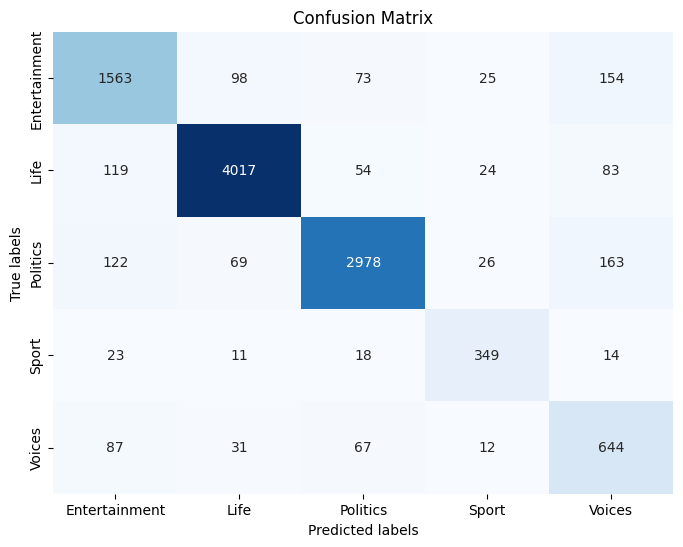

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1913
           1       0.95      0.93      0.94      4297
           2       0.93      0.89      0.91      3358
           3       0.80      0.84      0.82       415
           4       0.61      0.77      0.68       841

    accuracy                           0.88     10824
   macro avg       0.82      0.85      0.83     10824
weighted avg       0.89      0.88      0.88     10824



In [10]:
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test.to_numpy(), axis=1)

plotting.plot_confusion_matrix(y_pred2, y_test2)

print(classification_report(y_pred2, y_test2))

In [11]:
bidirLSTM.save_model()

In [12]:
bidirLSTM.bidirLSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 300)      │    26,482,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 200)      │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,908,665 (102.65 MB)

 Trainable params: 426,165 (1.63 MB)

 Non-trainable params: 26,482,500 (101.02 MB)